In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr
import sys
import csv
from generate_sim_data import gen_sim_data

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import fit_polynomial_methods as fit
import data_organize as dorg

C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
## Start by loading and organizing the data in preparation for the fit.

In [3]:
# Adjust parameters here to customize run

### CONSTANTS ####
c = 2.99792458e8                      # [m/s] Speed of light
dt = 25e-12                   # [s] TCSPC resolution

### PARAMETERS ###
window_bnd = [29.5e-9, 33e-9]       # [s] Set boundaries for binning to exclude outliers
exclude_shots = True                     # Set TRUE to exclude data to work with smaller dataset
max_lsr_num = int(5e5)                   # If set_max_det set to FALSE, include up to certain number of laser shots
max_det_num = 2000                       # If set_max_det set to TRUE, include up to a certain number of detections
set_max_det = False                          # Set TRUE if data limiter is number of detections instead of laser shots.
deadtime = 25e-9                  # [s] Acquisition deadtime
use_stop_idx = True               # Set TRUE if you want to use up to the OD value preceding the reference OD
run_full = True                   # Set TRUE if you want to run the fits against all ODs. Otherwise, it will just load the reference data.
include_deadtime = True  # Set True to include deadtime in noise model
use_poisson_eval = True  # Set TRUE if you want to use the Poisson model for the evaluation loss
use_sim_data = True  # Set TRUE if using simulated data from 'generate_sim_data.py'

# Make sure file location is accurate
cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_11.17.49.ARSENL.OD20.ARSENL.nc'


In [22]:
# Load / generate important data structures from simulated / real datsets 
# NOTE: If user wants to test different parameters with simulated data, look into "generate_sim_data.py"

if use_sim_data:
    # Only need to change this file location if using simulated data generated from "generate_sim_data.py"
    load_sim_pkl_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Data\simulated'
    fname_sim_pkl = r'\sim_amp5.0E+08_nshot1.0E+05.pkl'
    infile = open(load_sim_pkl_dir+fname_sim_pkl, 'rb')
    df = pickle.load(infile)
    infile.close()
    
    flight_time = xr.DataArray(df.flight_time.data)
    true_flight_time = xr.DataArray(df.true_flight_time.data)
    n_shots = df.n_shots.data
    t_det_lst = df.t_det_lst.data
    t_phot_lst = df.t_phot_lst.data
    target_amplitude = df.target_amplitude.data
    target_time = df.target_time.data
    laser_pulse_width = df.laser_pulse_width.data
    window_bnd = df.window_bnd.data
    background = df.background.data
else:
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, 
                                                         max_lsr_num, max_det_num, 
                                                         set_max_det, exclude_shots)
    
print('Number of detections: {}'.format(len(flight_time)))
print('Number of laser shots: {}'.format(n_shots))

Number of detections: 46613
Number of laser shots: 100000


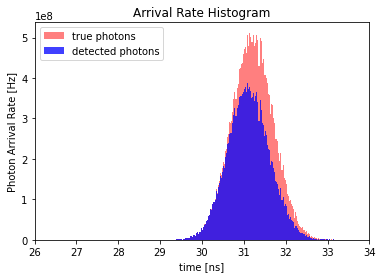

In [23]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)

bin_array = np.arange(window_bnd[0]*1e9, (window_bnd[1]+25e-12)*1e9, 25e-12*1e9)
if use_sim_data:
    n, bins = np.histogram(true_flight_time*1e9, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / 1e-9 / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='r', alpha=0.5, label='true photons')
n, bins = np.histogram(flight_time*1e9, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.75, label='detected photons')
ax.set_xlim(window_bnd*1e9)
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
plt.legend()
plt.show()